## Chapter 2 [Diffraction](Ch3-_Diffraction.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />
# Plotting of Diffraction Pattern
part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Import numerical and plotting python packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

# 3D plotting package used
from mpl_toolkits.mplot3d import Axes3D # 3D plotting 

# additional package 
import  itertools 
import scipy.constants as const

# Import libraries from the book
# Import libraries from the book
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library


Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
windows



## Define Silicon crystal

In [3]:
#Initialize the dictionary with all the input
tags = ks.structure_by_name('Silicon')
print(tags['elements'])
print(tags['base'])

#Reciprocal Lattice 
# We use the linear algebra package of numpy to invert the unit_cell "matrix"
reciprocal_unit_cell = np.linalg.inv(tags['unit_cell']).T # transposed of inverted unit_cell


['Si']
['Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si']
[(0.0, 0.0, 0.0), (0.5, 0.0, 0.5), (0.5, 0.5, 0.0), (0.0, 0.5, 0.5), [0.25, 0.25, 0.25], [0.75, 0.25, 0.75], [0.75, 0.75, 0.25], [0.25, 0.75, 0.75]]


## All Possible and Allowed Reflections

see [Kinematic Scattering Geometry](Kinematic Scattering Geometry.ipynb)  

and [Kinematic Scattering Calculation](Kinematic Scattering Calculation.ipynb)  

for details

In [19]:
#INPUT
zone_hkl = np.array([1,1,0])
hkl_max = 35#  maximum allowed Miller index
Sg_max = .3 # 1/nm  maximum allowed excitation error

acceleration_voltage_V = 200.0 *1000.0 #V
wave_length_nm  = ks.get_waveLength(acceleration_voltage_V)

#Incident wave vector K0 in vacuum and material 
U0 = 0
for i in range(len(tags['elements'])):
    a = tags['elements'][i]
    U0 += ks.feq(a,0)*0.023933754

volume =  np.linalg.det(tags['unit_cell'])*1000. # Needs to be in Angstrom for form factors
AngstromConversion = 1.0e10 # So [1A (in m)] * AngstromConversion = 1
NanometerConversion = 1.0e9 

ScattFacToVolts=(const.h**2)*(AngstromConversion**2)/(2*np.pi*const.m_e*const.e)*volume
U0=U0*ScattFacToVolts
print('The inner potential is {0:.1f}kV'.format(U0/1000))

incident_wave_vector_vacuum = 1/wave_length_nm
K0 = incident_wave_vector = np.sqrt(1/wave_length_nm**2 + U0 )#1/nm

cent = np.dot(zone_hkl,reciprocal_unit_cell)
cent = cent /np.linalg.norm(cent)* incident_wave_vector

# zone axis in global coordinate system
zone_vector = np.dot(zone_hkl,reciprocal_unit_cell)

h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all evaluated single Miller Indices
hkl  = np.array(list(itertools.product(h,h,h) )) # all evaluated Miller indices
g = np.dot(hkl,reciprocal_unit_cell)               # all evaluated reciprocal lattice points

# Calculate exitation errors for all reciprocal lattice points
## Zuo and Spence, 'Adv TEM', 2017 -- Eq 3:14
S = (K0**2-np.linalg.norm(g - cent, axis =1)**2)/(2*K0)

# Determine reciprocal lattice points with excitation error less than the maximum allowed one: Sg_max
reflections = abs(S)< Sg_max

Sg = S[reflections]
g_hkl = g[reflections]
hkl = hkl[reflections] 
print ('Of the {0} tested reciprocal lattice points, {1} have an excitation error less than {2:.2f} 1/nm'.format( len(g) , len(g_hkl), Sg_max))

# Calculate Structure Factors

structure_factors = []

base = np.dot(tags['base'],tags['unit_cell'])
for j  in range(len(g_hkl)):
    F = 0
    for b in range(len(base)):
        f = ks.feq(tags['elements'][b],np.linalg.norm(g_hkl[j]))
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*base[b]).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)

allowed = np.absolute(structure_factors) > 0.000001

print('Of the {0} possible reflection {1} are allowed.'.format(hkl.shape[0], allowed.sum() ) )

# information of allowed reflections
Sg_allowed = Sg[allowed]
hkl_allowed = hkl[allowed][:]
g_allowed = g_hkl[allowed,:]
F_allowed = F[allowed]
intensities = np.absolute(F_allowed)**2 

# forbidden reflections:
forbidden = np.logical_not(allowed)
g_forbidden = g_hkl[forbidden,:]

# Determine Laue Zone for reflections
zone_axis = np.dot(zone_hkl,tags['unit_cell'])
Laue_Zone = np.floor(abs(np.dot(hkl_allowed,zone_hkl)))# works only for cubic crystal systems
#Laue_Zone = np.floor(abs(np.dot(g_allowed,zone_axis)) ) # works for all crystal systems
ZOLZ = Laue_Zone ==0
HOLZ = Laue_Zone > 1

print ('Of those, there are {0} in ZOLZ and {1} in HOLZ'.format(ZOLZ.sum(),HOLZ.sum()))

intensities = np.absolute(F_allowed)**2 


The inner potential is 9.7kV
Of the 357911 tested reciprocal lattice points, 2207 have an excitation error less than 0.30 1/nm
Of the 2207 possible reflection 413 are allowed.
Of those, there are 67 in ZOLZ and 346 in HOLZ


## Plotting of Ewald Sphere



<IPython.core.display.Javascript object>


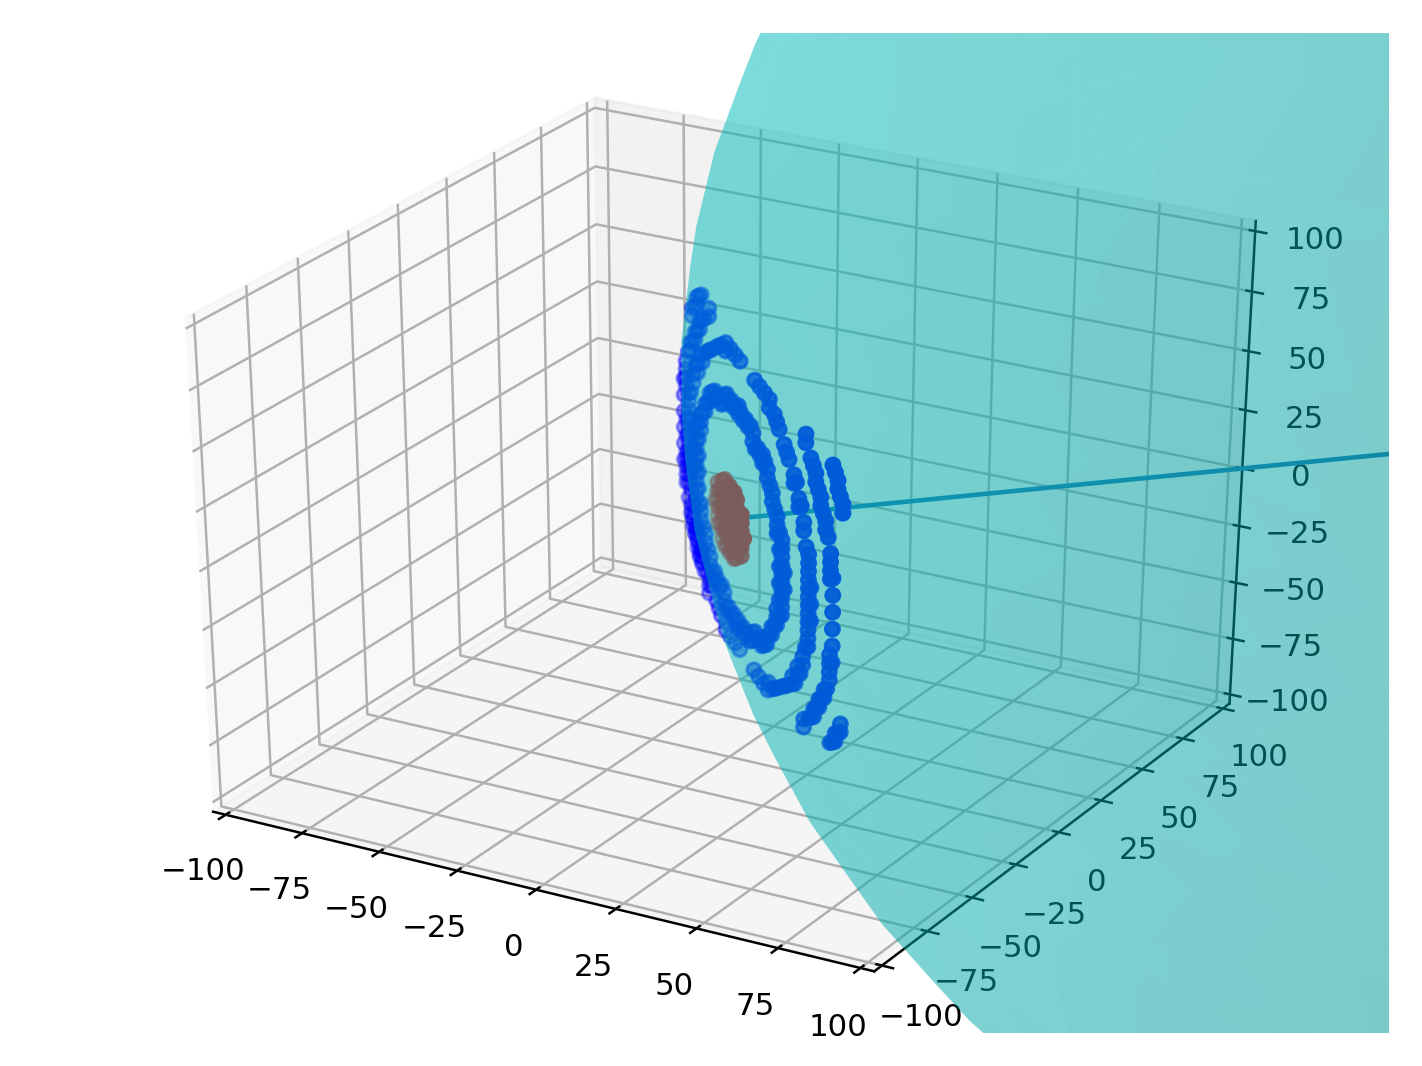

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(cent[0], cent[1], cent[2], c='green')
ax.plot((cent[0], 0), (cent[1], 0), (cent[2],0)) 

# draw sphere
u, v = np.mgrid[0:2*np.pi:80j, 0:np.pi:40j]
x = np.cos(u)*np.sin(v)*K0+cent[0]
y = np.sin(u)*np.sin(v)*K0+cent[1]
z = np.cos(v)*K0+cent[2]

ax.scatter(g_allowed[ZOLZ,0], g_allowed[ZOLZ,1], g_allowed[ZOLZ,2], c='red')
ax.scatter(g_allowed[HOLZ,0], g_allowed[HOLZ,1], g_allowed[HOLZ,2], c='blue')
ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

ax.set_xlim([-100,100])
ax.set_ylim([-100,100])
ax.set_zlim([-100,100])
#ax.set_aspect("equal"); 
plt.tight_layout(); plt.show()

<IPython.core.display.Javascript object>


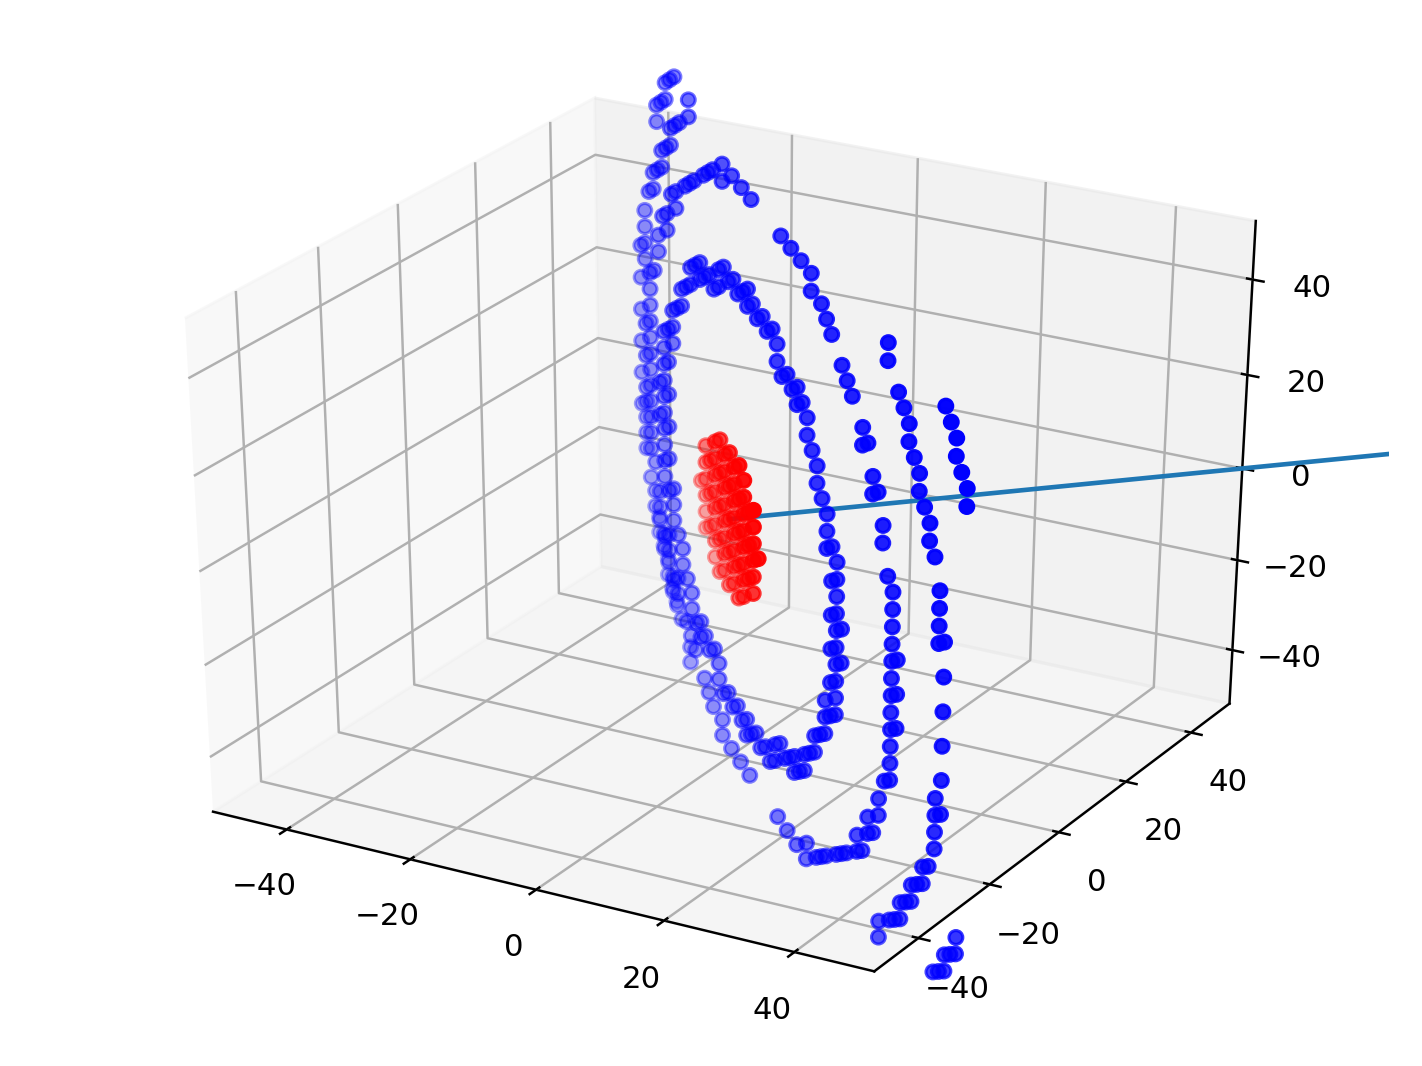

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(g_allowed[ZOLZ,0], g_allowed[ZOLZ,1], g_allowed[ZOLZ,2], c='red')
ax.scatter(g_allowed[HOLZ,0], g_allowed[HOLZ,1], g_allowed[HOLZ,2], c='blue')

ax.scatter(cent[0], cent[1], cent[2], c='green')
ax.plot((cent[0], 0), (cent[1], 0), (cent[2],0)) 
33
ax.set_xlim([-50,50])
ax.set_ylim([-50,50])
ax.set_zlim([-50,50])
#ax.set_aspect("equal"); 
plt.tight_layout(); plt.show()

## Projection
We need to project the active reciprocal points onto the plane perpendicular to the zone axis.

For that we tilt the zone axis onto the z-axis

We use the spherical coordiantes to determine the rotation matrix


In [23]:
def get_rotation_matrix(zone):
    
    #spherical coordinates of zone
    r = np.linalg.norm(zone)
    theta = np.arccos(zone[2]/r)
    if zone[0] < 0:
        theta = -theta
    if zone[0] == 0:
        phi= np.pi/2
    else: 
        phi = (np.arctan(zone[1]/zone[0]))

    print('Rotation theta ',np.degrees(theta),' phi ',np.degrees(phi))

    #first we rotate phi about z-axis
    c, s = np.cos(phi), np.sin(phi)
    rotz = np.array([[c, -s , 0],[s,c,0],[0,0,1]])

    # second we rotate theta about y axis
    c, s = np.cos(theta), np.sin(theta)
    roty = np.array([[c, 0 ,s],[0,1,0],[-s,0,c]])
    
    # the rotation now makes z-axis coincide with plane normal
    return np.dot(rotz,roty), np.degrees(theta), np.degrees(phi)
# zone axis in global coordinate system

zone_vector = np.dot(zone_hkl,reciprocal_unit_cell)
rotation_matrix, theta, phi = get_rotation_matrix(zone_vector)

print(rotation_matrix)

print('\n Zone axis can now be rotated parallel to z axis')
print(np.dot(zone_vector,rotation_matrix))

Rotation theta  90.0  phi  45.0
[[ 4.32978028e-17 -7.07106781e-01  7.07106781e-01]
 [ 4.32978028e-17  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  0.00000000e+00  6.12323400e-17]]

 Zone axis can now be rotated parallel to z axis
[1.52778115e-16 6.84752235e-17 2.49505597e+00]


## Rotation
We use the rotation matrix to rotate all lattice vectors

In [24]:
K0_vector_rotated = np.dot(cent, rotation_matrix)
cent_rotated = K0_vector_rotated
print(cent_rotated)

g_hkl_rotated = np.dot(g_allowed, rotation_matrix)

[2.51496596e-14 5.38663586e-15 4.10725111e+02]


Now we can plot these diffraction spots in 2D by just setting the z-coordinate to zero. That is our projection procedure.

<IPython.core.display.Javascript object>


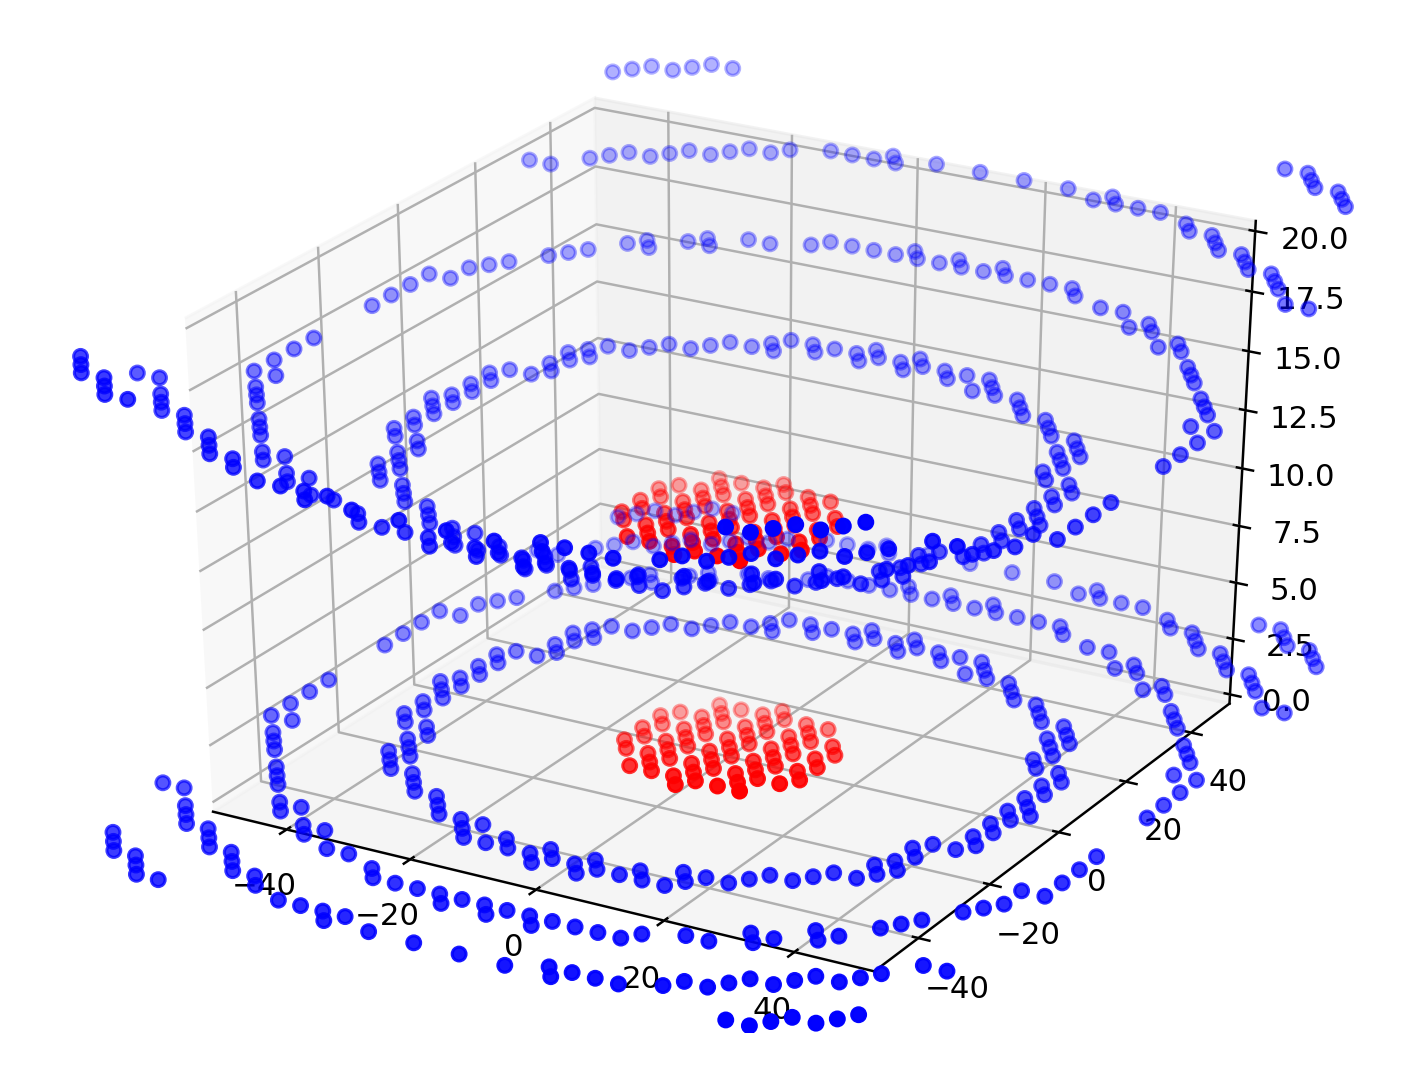

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], g_hkl_rotated[ZOLZ,2]+10, c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], g_hkl_rotated[HOLZ,2]+10, c='blue')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], 0, c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], 0, c='blue')

ax.set_xlim([-50,50])
ax.set_ylim([-50,50])
ax.set_zlim([0,20])
#ax.set_aspect("equal"); 
plt.tight_layout(); plt.show()

In the above graph the z-axis is much smaller than the x,y axis.

In perspecttive to the incident beam wave vector the ewald sphere appears flat already.

<IPython.core.display.Javascript object>


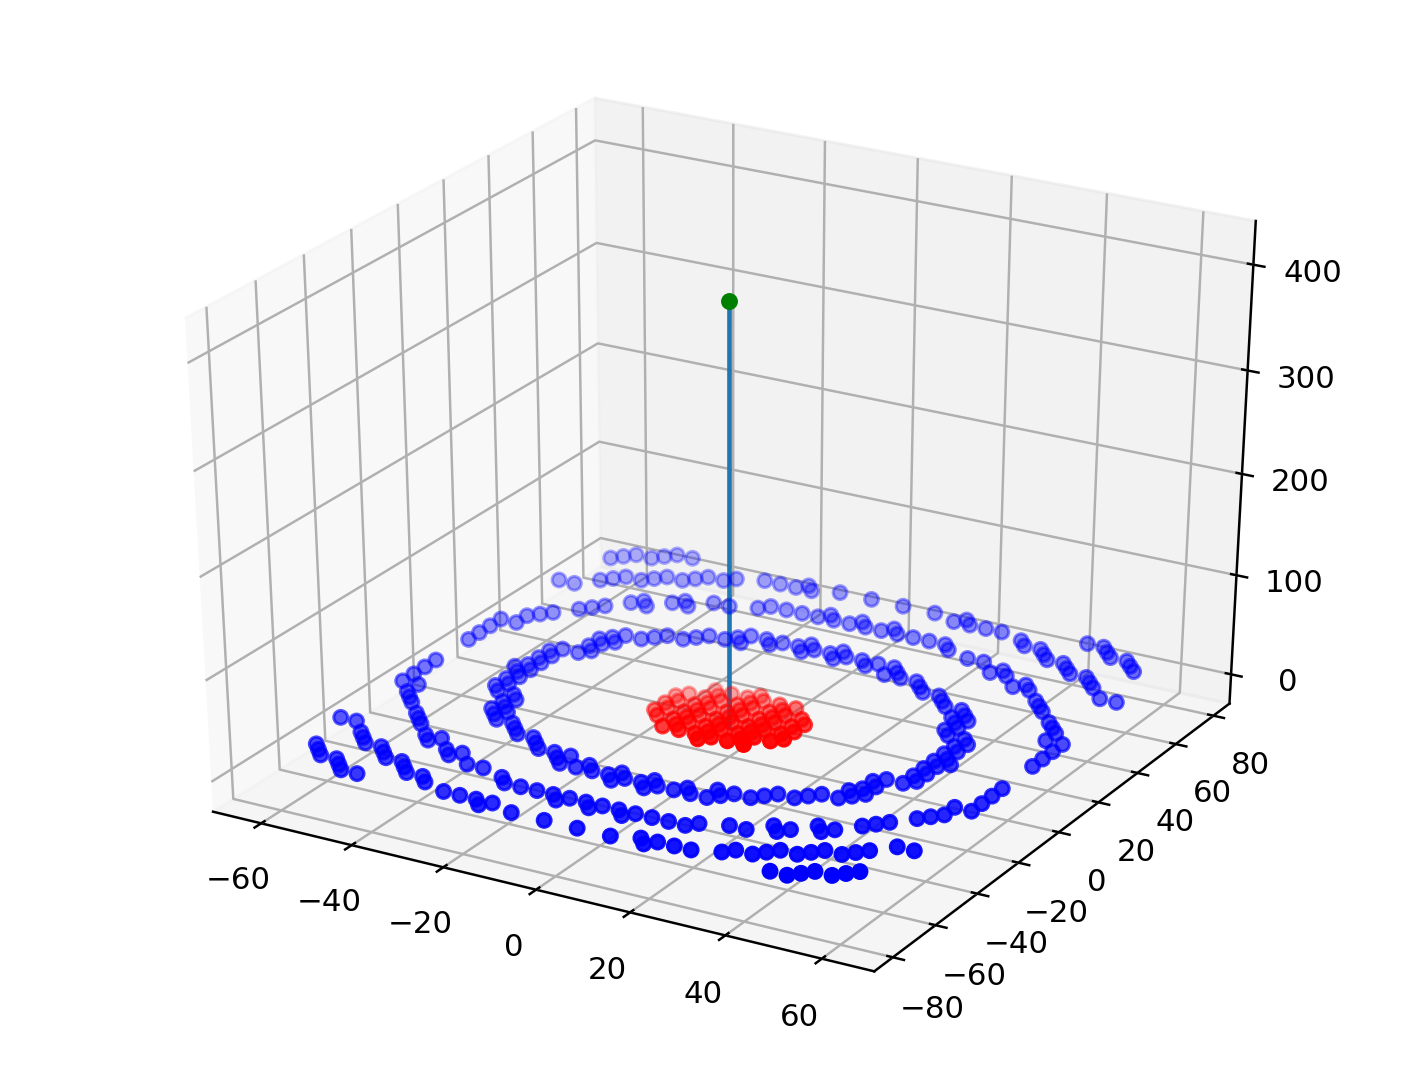

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], g_hkl_rotated[ZOLZ,2]+10, c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], g_hkl_rotated[HOLZ,2]+10, c='blue')

ax.scatter(cent_rotated[0], cent_rotated[1], cent_rotated[2], c='green')
ax.plot((cent_rotated[0], 0), (cent_rotated[1], 0), (cent_rotated[2],0)) 
#ax.set_aspect("equal"); 
plt.tight_layout(); plt.show()

## 2D projection
To compare this simulation with an experimental diffraction pattern, we only need the 2D projection.

Please note that all calculations were done without rotation. Only the plotting requires that. So rotation and setting the z-coordinate to zero is our prjection procedure.

<IPython.core.display.Javascript object>


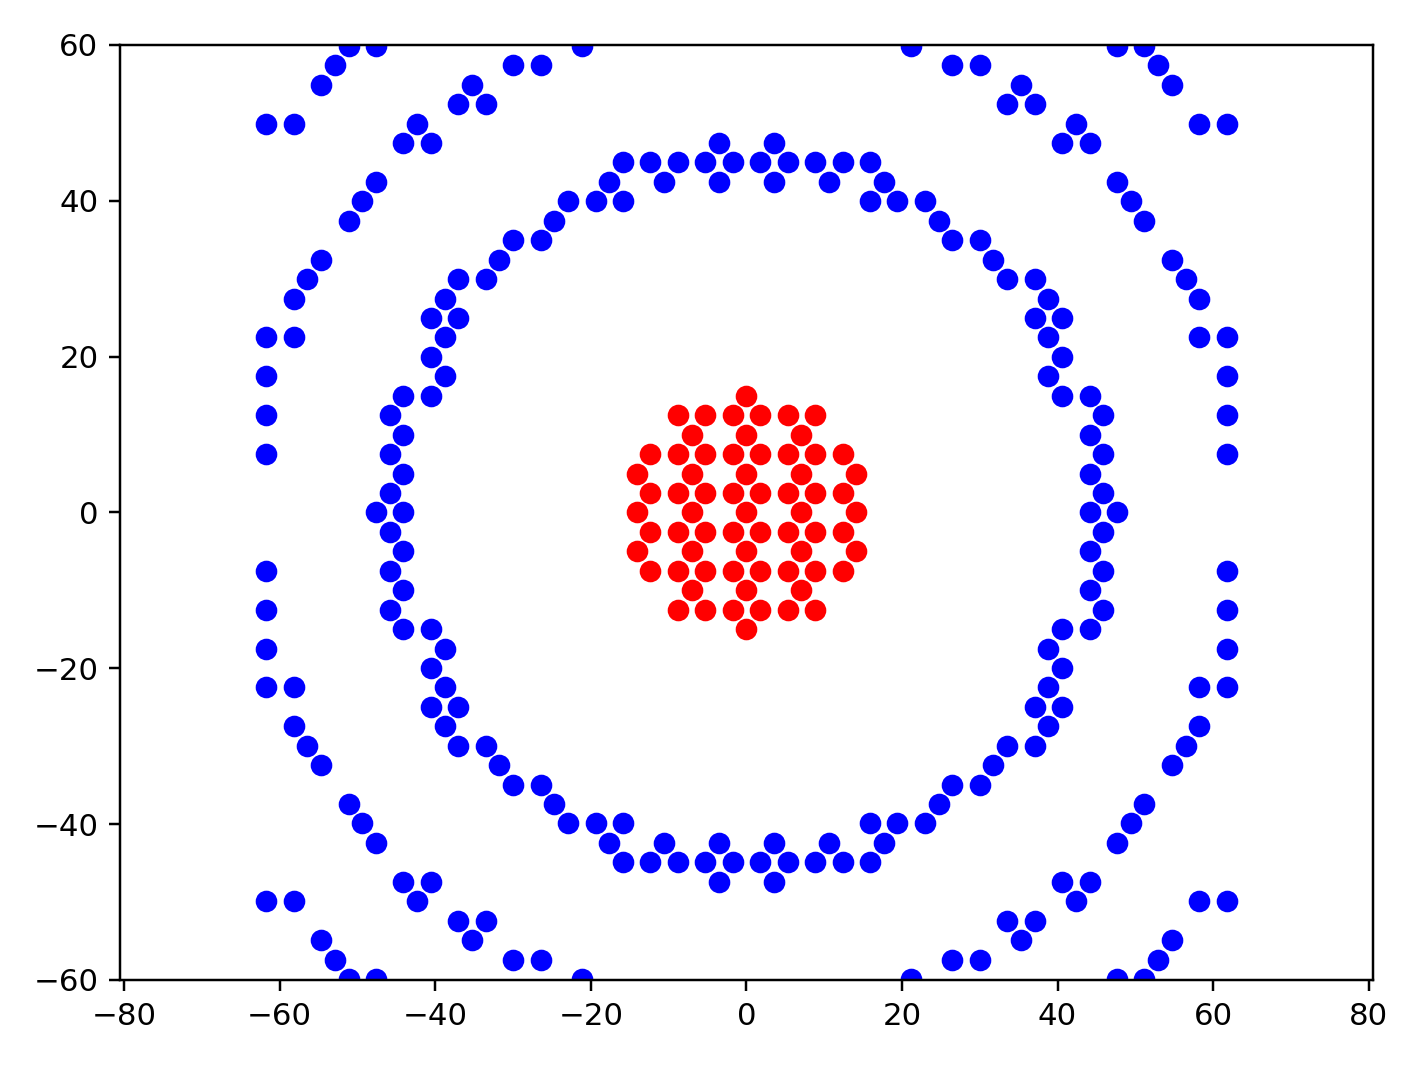

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], c='blue')
## Add indices
#for i in range (ZOLZ_plot.sum()):
#    ax.text(g_hk_rotatted[ZOLZ_plot][i,0]-2.5, g_hk_rotatted[ZOLZ_plot][i,1]+1.2,hkl[ZOLZ_plot][i],fontsize=10)
#for i in range (HOLZ_plot.sum()):
#    ax.text(g_hk_rotatted[HOLZ_plot][i,0]-2.5, g_hk_rotatted[HOLZ_plot][i,1]+1.2,hkl[HOLZ_plot][i],fontsize=10)
ax.axis("equal")
ax.set_xlim([-60,60])
ax.set_ylim([-60,60])
plt.tight_layout(); plt.show()

## Forbidden Reflections
We can now pot the forbidden reflections into this diffraction pattern.

As can be seen the first order Laue Zone (SOLZ) is completely forbidden as are all the other odd Laue Zones.


<IPython.core.display.Javascript object>


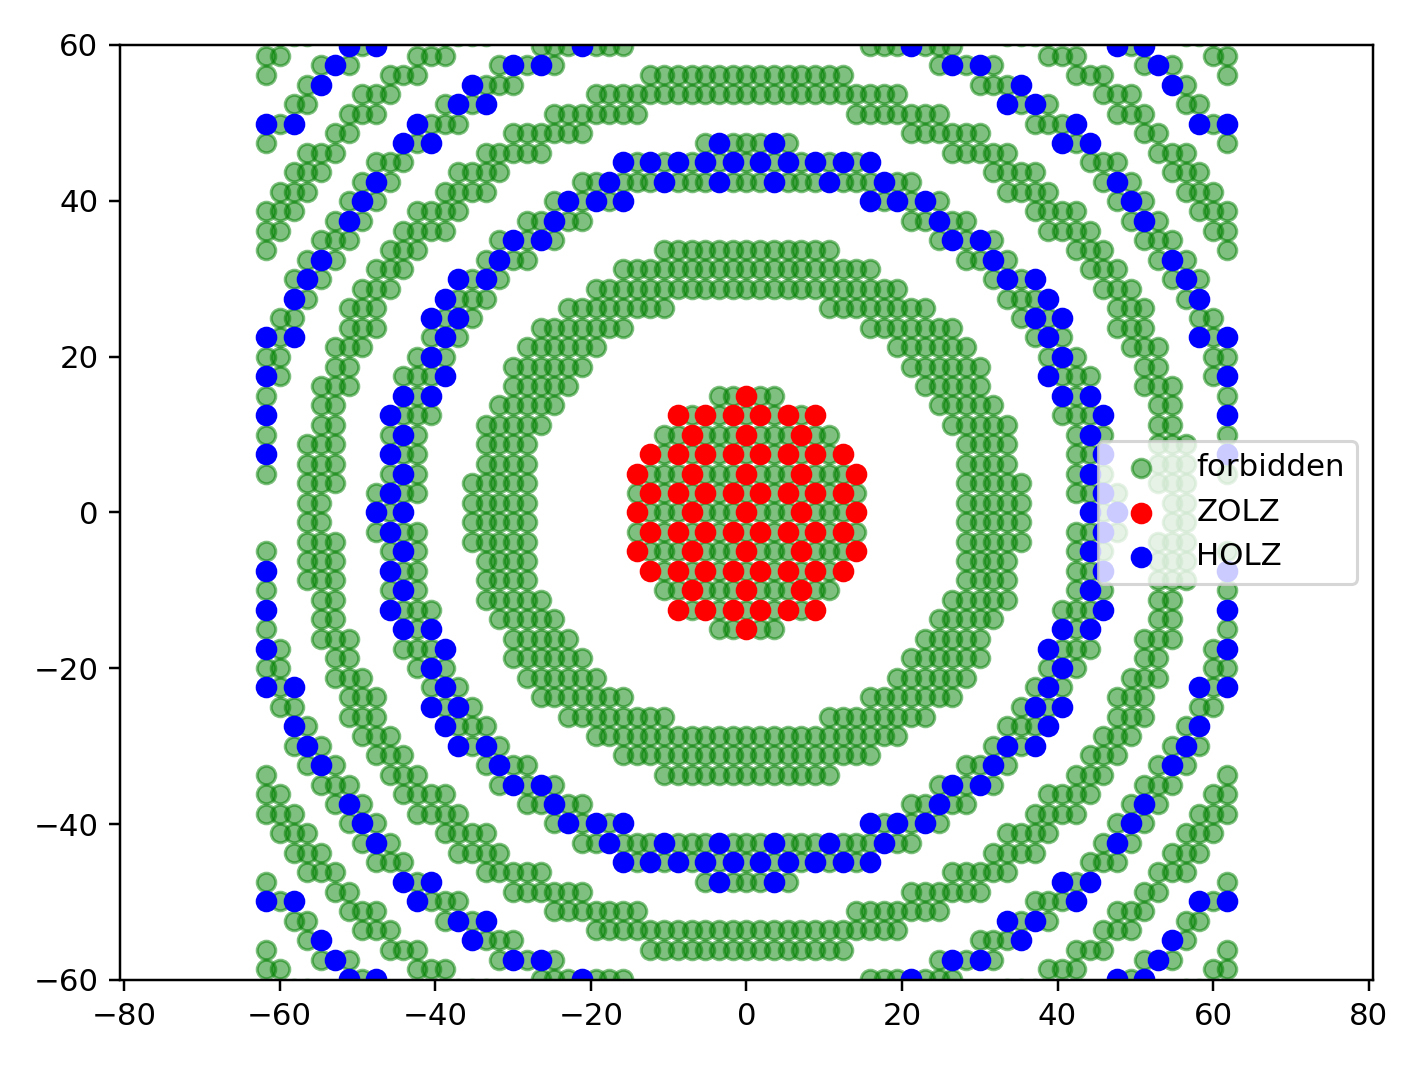

In [28]:

fig = plt.figure()
ax = fig.add_subplot(111)
forbidden = np.dot(g_forbidden, rotation_matrix)
ax.scatter(forbidden[:,0], forbidden[:,1], c='green', alpha = 0.5, label='forbidden')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], c='red', label='ZOLZ')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], c='blue', label='HOLZ')
ax.axis('equal')
ax.set_xlim([-60,60])
ax.set_ylim([-60,60])
plt.legend()
plt.tight_layout(); plt.show()

## Kinematic Scattering with KinsCat
the kineamtic scattering plots can be calculated with the provided KinsCat module. All data are gathered in a python dictionary named <b> tags<b>.

<IPython.core.display.Javascript object>


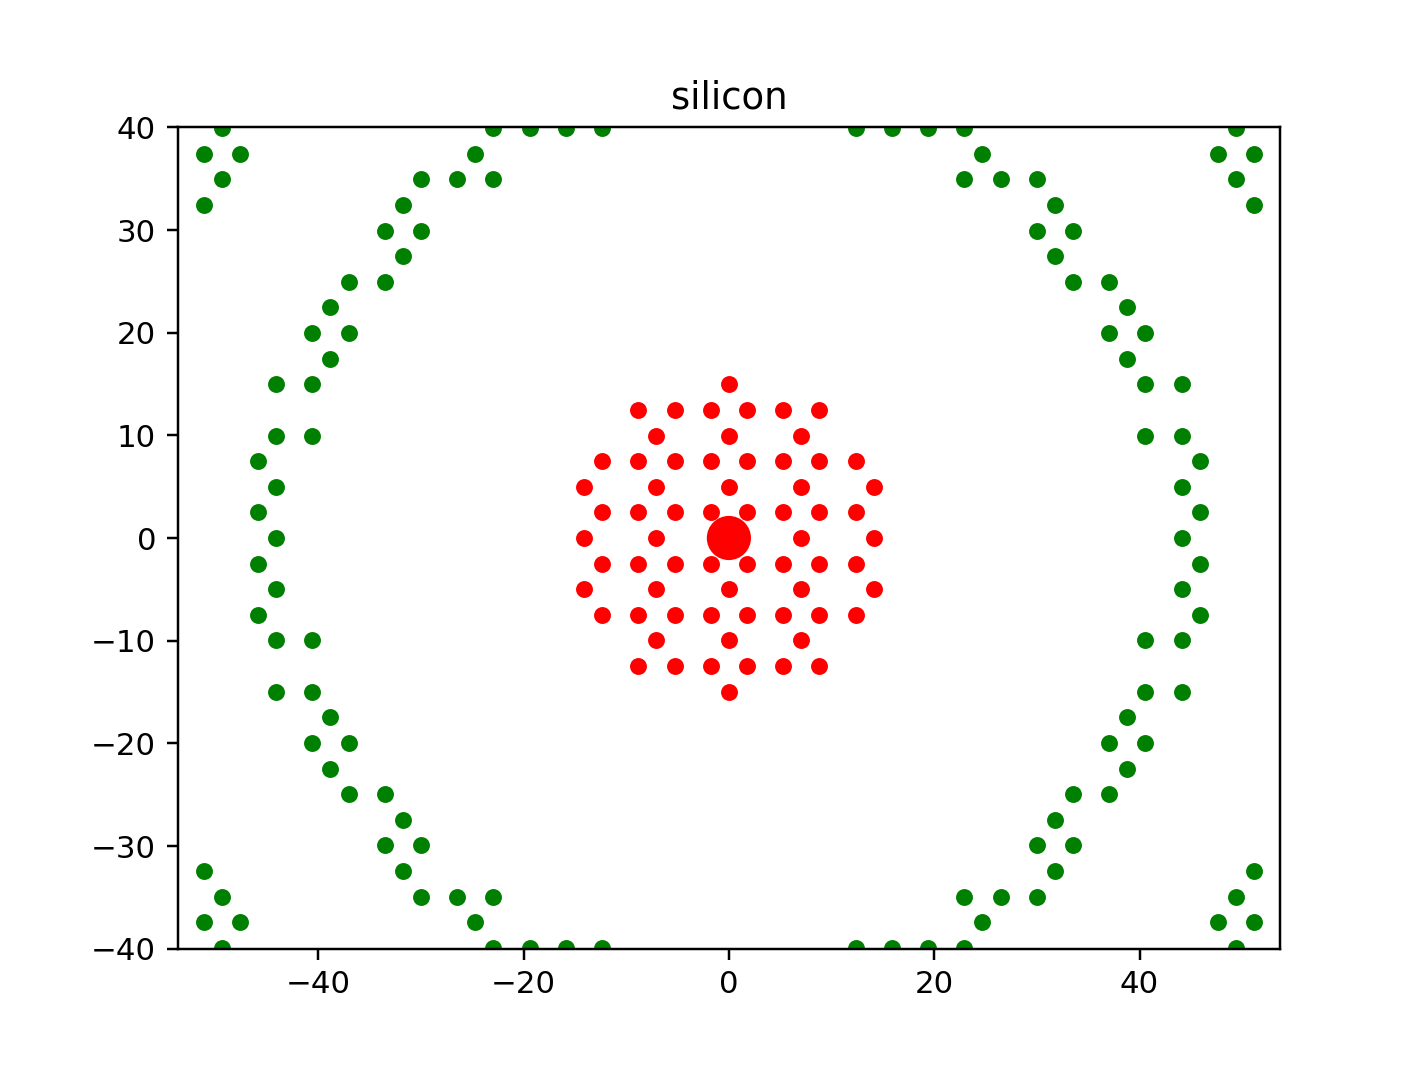

In [29]:
# copy experimental conditions into the tags directory

tags['acceleration_voltage_V'] =acceleration_voltage_V

tags['convergence_angle_mrad'] = 0

tags['zone_hkl'] = zone_hkl # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([0,0,0])  # mistilt in degrees

tags['Sg_max'] = Sg_max # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = hkl_max   # Highest evaluated Miller indices
# calulcuate kinematic scattering data
ks.Kinematic_Scattering(tags, False)
tags['plot FOV'] = 40
# plot diffraction pattern
ks.plotSAED(tags)

## Conclusion
The scattering geometry provides all the tools to determine which reciprocal lattice points are possible and which of them are allowed.

The diffraction pattern is a projection onto the plane perpendicular to the zone axis. For an easy projection we tilt everythng so that the x,y plane  is our projection plane.

## Back: [Kinematic Scattering Geometry](CH2-Kinematic_Scattering_Geometry.ipynb)
## Next: [Analyzing Spot Diffraction Pattern](CH2-Spot_Diffraction_Pattern.ipynb)
## Chapter 2: [Diffraction](Diffraction.ipynb)
## List of Content: [Front](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)
